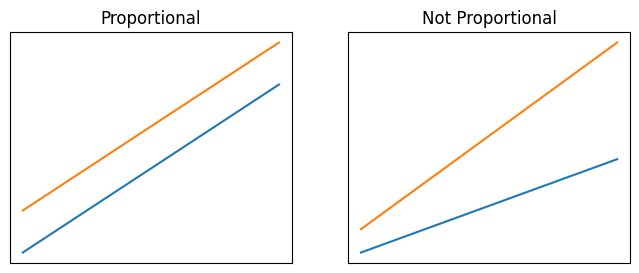

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##成比例的和不成比例的
##重点：平行则比例风险假设成立，不同组的kmf曲线差距恒定，表明不同组差异对于时间是稳定的
##不平行则比例风险假设不成立，表明不同组差异随时间会发生变化
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))

ax1.plot([1,2,3,4,5],[1,2,3,4,5])
ax1.plot([1,2,3,4,5],[2,3,4,5,6])
ax1.title.set_text('Proportional')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

ax2.plot([1,2,3,4,5],[1,2,3,4,5])
ax2.plot([1,2,3,4,5],[2,4,6,8,10])
ax2.title.set_text('Not Proportional')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

In [3]:
##导入intro处理后的csv文件，并转换成pandas dataframe以进行后续的处理
from pyspark.sql import SparkSession
from pyspark import SparkConf
conf = SparkConf().setAppName("Project Q2").set("spark.jars", "/data/lab/mysql-connector-j-8.4.0.jar")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

silver_path = "silver_data.csv"
telco_pd = spark.read.format('csv').option('header','true').load(silver_path).toPandas()

25/04/11 09:31:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/11 09:31:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/04/11 09:31:37 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/04/11 09:31:37 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/04/11 09:31:37 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
25/04/11 09:31:37 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
25/04/11 09:31:37 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.
25/04/11 09:31:37 WARN Utils: Service 'SparkUI' could not bind on port 4046. Attempting port 4047.
25/04/11 09:31:37 WARN Utils: Serv

In [5]:
##把选中的列转换为独热变量，将分类变量的各个类拆分成不同列，类型为True，False判断
encode_cols = ['dependents','internetService','onlineBackup','techSupport','paperlessBilling']

encoded_pd = pd.get_dummies(telco_pd,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)

encoded_pd.head()

,customerID,gender,seniorCitizen,partner,tenure,phoneService,multipleLines,onlineSecurity,deviceProtection,streamingTV,...,dependents_No,dependents_Yes,internetService_DSL,internetService_Fiber optic,onlineBackup_No,onlineBackup_Yes,techSupport_No,techSupport_Yes,paperlessBilling_No,paperlessBilling_Yes
0,7590-VHVEG,Female,0.0,Yes,1.0,No,No phone service,No,No,No,...,True,False,True,False,False,True,True,False,False,True
1,3668-QPYBK,Male,0.0,No,2.0,Yes,No,Yes,No,No,...,True,False,True,False,False,True,True,False,False,True
2,9237-HQITU,Female,0.0,No,2.0,Yes,No,No,No,No,...,True,False,False,True,True,False,True,False,False,True
3,9305-CDSKC,Female,0.0,No,8.0,Yes,Yes,No,Yes,Yes,...,True,False,False,True,True,False,True,False,False,True
4,1452-KIOVK,Male,0.0,No,22.0,Yes,Yes,No,No,Yes,...,False,True,False,True,False,True,True,False,False,True


In [6]:
##提取生存分析所需要的数据列，并对数据列类型转换，方便后续分析（比较）
survival_pd = encoded_pd[['churn','tenure','dependents_Yes','internetService_DSL','onlineBackup_Yes','techSupport_Yes']]
survival_pd.loc[:,'churn'] = survival_pd.loc[:,'churn'].astype('float')

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 3351
number of events observed = 1556
   partial log-likelihood = -11178.40
         time fit was run = 2025-04-11 09:59:50 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
dependents_Yes      -0.10      0.90      0.07           -0.24            0.03                0.79                1.03
internetService_DSL -0.04      0.96      0.06           -0.15            0.07                0.86                1.07
onlineBackup_Yes    -0.35      0.71      0.06           -0.46           -0.23                0.63                0.79
techSupport_Yes     -0.21      0.81      0.07           -0.34           -0.08                0.71                0.92

                     cmp to     z      p  -log2(p)
covariate                                         
dependents_Yes         0.00 -1.52   0.13      2.95
internetService_DSL    0.00 -0.78   0.44      1.19
onlineBackup_Yes       0.00 -6.06 <0.005     29.49
techSupport_Yes        0.00 -3.11 <0.005      9.06
---
Concordance = 0.64
Partial AIC = 22364.80
log-likelihood ratio test = 57.57 on 4 df
-log2(p) of ll-ratio test = 36.63

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)



   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
dependents_Yes      km              3.85   0.05      4.33
                    rank            1.11   0.29      1.78
internetService_DSL km             48.21 <0.005     37.93
                    rank           15.59 <0.005     13.63
onlineBackup_Yes    km            106.63 <0.005     80.63
                    rank           47.80 <0.005     37.62
techSupport_Yes     km             13.68 <0.005     12.17
                    rank           10.23 <0.005      9.50



1. Variable 'dependents_Yes' failed the non-proportional test: p-value is 0.0498.

   Advice: with so few unique values (only 2), you can include `strata=['dependents_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'internetService_DSL' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['internetService_DSL', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'onlineBackup_Yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['onlineBackup_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


4. Variable 'techSupport_Yes' failed the non-proportional test: p-value is 0.0002.

   Advice: with so

[[<Axes: xlabel='rank-transformed time\n(p=0.2914)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0498)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0001)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0014)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0002)'>]]

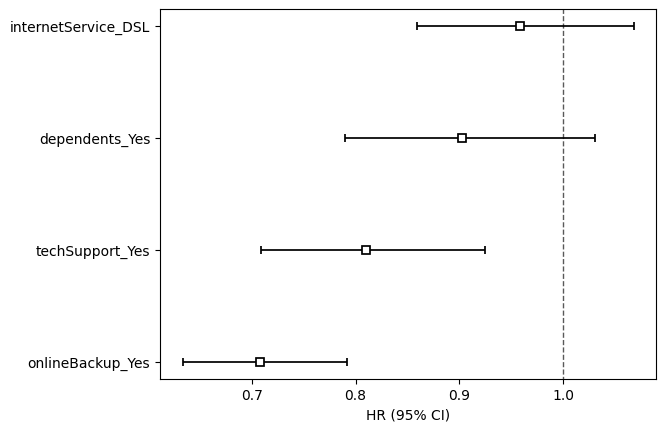

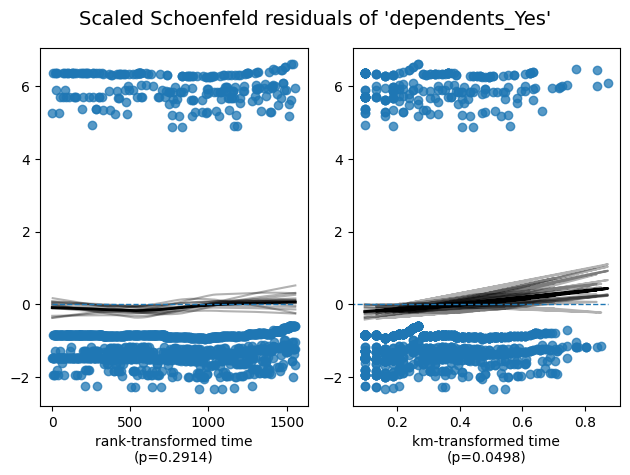

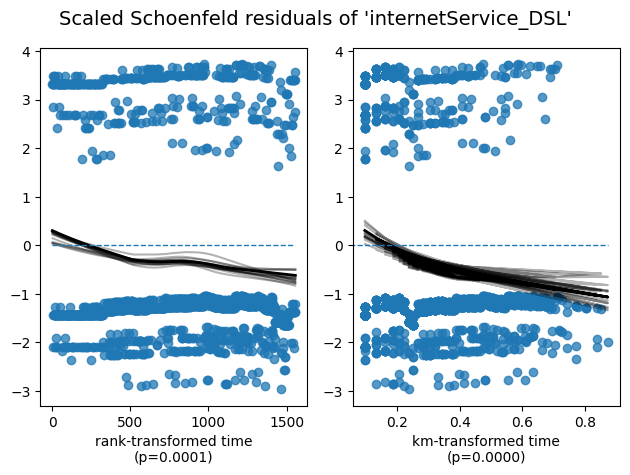

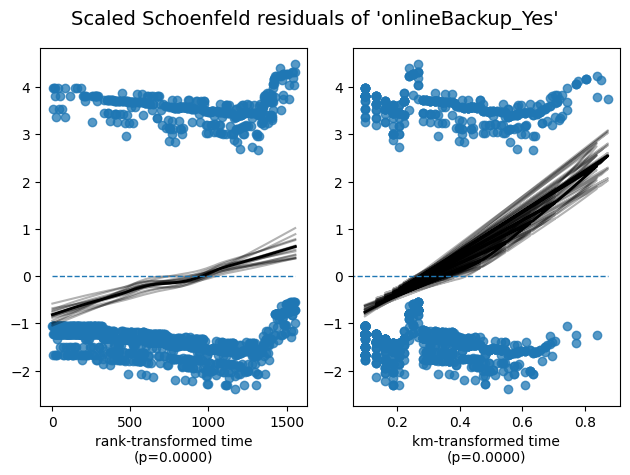

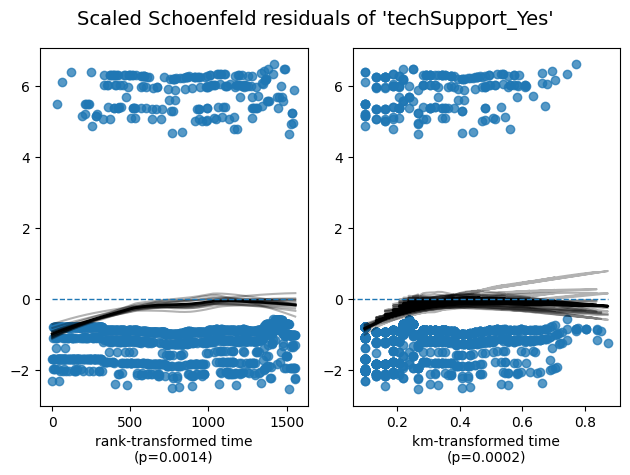

In [9]:
##初始化一个cph模型
cph = CoxPHFitter(alpha=0.05)

cph.fit(survival_pd, 'tenure', 'churn')
cph.print_summary()
cph.plot(hazard_ratios=True)
cph.check_assumptions(survival_pd,p_value_threshold=0.05,show_plots=True)
##通过cph模型直接地展现survival_pd里选中的变量是否对客户流失有显著影响

In [10]:
##初始化一个kmf模型（同第二题）
kmf = KaplanMeierFitter()

telco_pd['tenure'] = pd.to_numeric(telco_pd['tenure'], errors='coerce')
T=telco_pd['tenure']
C=telco_pd['churn'].astype(float) 
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3351 total observations, 1795 right-censored observations>

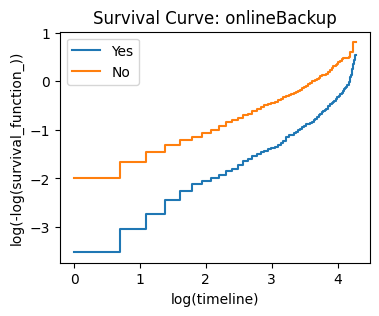

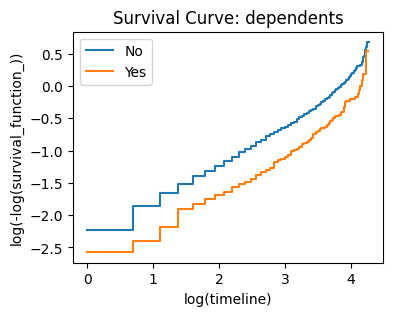

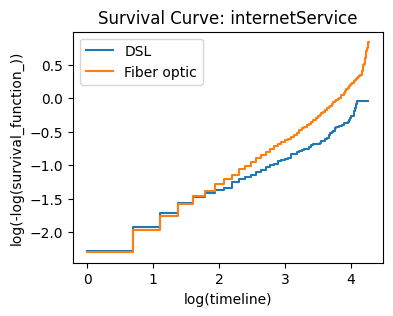

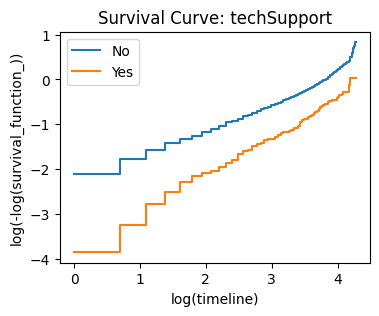

In [14]:
##以loglog方法来绘制kmf模型的曲线图，通过是否平行，体现每个选中变量组间差异是否恒定，或随时间的变化情况
import matplotlib.pyplot as plt
def plot_km_loglog(col):
  fig, ax = plt.subplots(figsize=(4,3))
  for r in telco_pd[col].unique():
    ix = telco_pd[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot_loglogs(ax=ax,title =f'Survival Curve: {col}')

plot_km_loglog('onlineBackup')

plot_km_loglog('dependents')

plot_km_loglog('internetService')

plot_km_loglog('techSupport')